In [1]:
from utils import *

import os, cv2
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def data_loader_v1(PATH, val_idx = 0):
    train_t1 = None
    train_dante = None
    Pat_lists = sorted(os.listdir(PATH))
    val_pat = Pat_lists[val_idx]
    Pat_lists.pop(val_idx)
    for i, pat in enumerate(Pat_lists):
        Pat_path = os.path.join(PATH, pat)
        tmp_t1, tmp_dante, _ = load_nii_multi(Pat_path)
        tmp_dante = np.transpose(tmp_dante, [2, 0, 1])
        tmp_dante = np.reshape(tmp_dante, [len(tmp_dante)//6, 6, 320, 256])
        tmp_dante = np.transpose(tmp_dante, [0, 2, 3, 1])
        tmp_t1 = np.expand_dims(np.transpose(tmp_t1, [2, 0, 1]), -1)
        if i==0:
            train_t1 = tmp_t1
            train_dante = tmp_dante
        else:
            train_t1 = np.concatenate([train_t1, tmp_t1], axis=0)
            train_dante = np.concatenate([train_dante, tmp_dante], axis=0)
    
    Pat_path = os.path.join(PATH, val_pat)
    val_t1, val_dante, _ = load_nii_multi(Pat_path)
    val_dante = np.transpose(val_dante, [2, 0, 1])
    val_dante = np.reshape(val_dante, [len(val_dante)//6, 6, 320, 256])
    val_dante = np.transpose(val_dante, [0, 2, 3, 1])
    val_t1 = np.expand_dims(np.transpose(val_t1, [2, 0, 1]), -1)
    
    return train_t1, train_dante, val_t1, val_dante


In [3]:
Data_root = '../MRI Enhancing/4gan_m'
train_t1, train_dante, val_t1, val_dante = data_loader_v1(Data_root)

print(train_t1.shape)
print(train_dante.shape)
print(val_t1.shape)
print(val_dante.shape)

(316, 320, 256, 1)
(316, 320, 256, 6)
(26, 320, 256, 1)
(320, 256, 156)


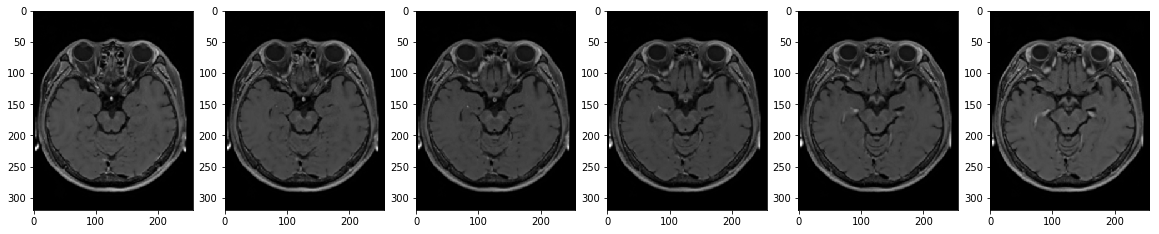

In [9]:
idx = 10
plt.figure(figsize=(20, 5))
plt.subplot(161)
plt.imshow(test[idx][..., 0], cmap='gray')
plt.subplot(162)
plt.imshow(test[idx][..., 1], cmap='gray')
plt.subplot(163)
plt.imshow(test[idx][..., 2], cmap='gray')
plt.subplot(164)
plt.imshow(test[idx][..., 3], cmap='gray')
plt.subplot(165)
plt.imshow(test[idx][..., 4], cmap='gray')
plt.subplot(166)
plt.imshow(test[idx][..., 5], cmap='gray')
plt.show()

In [2]:
def data_loader(PATH, val_idx = 0):
    train_low = []
    train_high = None
    
    val_low = []
    
    test_low = []
    
    Pat_lists = sorted(os.listdir(PATH))
    val_pat = Pat_lists[val_idx]
    Pat_lists.pop(val_idx)
    for i, pat in enumerate(Pat_lists):
        Pat_path = os.path.join(PATH, pat)
        tmp_t1, tmp_dante = load_nii_multi(Pat_path) # (H, W, S)
        h, w, s = tmp_dante.shape
        
        tmp_dante = np.array(np.dsplit(tmp_dante, s/6)) # (S/6, H, W, 6)
        
        # Make Train Low
        mean_dante = tmp_dante.mean(axis=-1)  # (S/6, H, W)
        for j in range(s//6):
            if j==0: continue
            empty = np.ones((3, h, w))
            if j==0:
                empty[1:,...] = mean_dante[:2]
            elif j==s/6-1:
                empty[:2,...] = mean_dante[-2:]
            else:
                empty = mean_dante[j-1:j+2]
            
            empty = np.transpose(empty, [1, 2, 0])
            train_low.append(empty)
        
        
        tmp_t1 = np.transpose(tmp_t1, (2, 0, 1)) # (S, H, W)
        for j in range(s//6):
            if j==0 continue
            empty = np.ones((3, h, w))
            if j==0:
                empty[1:,...] = tmp_t1[:2]
            elif j==s/6-1:
                empty[:2,...] = tmp_t1[-2:]
            else:
                empty = tmp_t1[j-1:j+2]
            
            empty = np.transpose(empty, [1, 2, 0])
            test_low.append(empty)
            
        if i==0:
            train_high = tmp_dante
        else:
            train_high = np.concatenate([train_high, tmp_dante], axis=0)
    
    Pat_path = os.path.join(PATH, val_pat)
    test_t1, val_high = load_nii_multi(Pat_path)
    h, w, s = val_high.shape
    val_high = np.array(np.dsplit(val_high, s/6))
    mean_dante = val_high.mean(axis=-1)  # (S/6, H, W)
    for j in range(s//6):
        if j==0: continue
        empty = np.ones((3, h, w))
        if j==0:
            empty[1:,...] = mean_dante[:2]
        elif j==s/6-1:
            empty[:2,...] = mean_dante[-2:]
        else:
            empty = mean_dante[j-1:j+2]

        empty = np.transpose(empty, [1, 2, 0])
        val_low.append(empty)


    test_t1 = np.transpose(test_t1, (2, 0, 1)) # (S, H, W)
    for j in range(s//6):
        if j==0:continue
        empty = np.ones((3, h, w))
        if j==0:
            empty[1:,...] = test_t1[:2]
        elif j==s/6-1:
            empty[:2,...] = test_t1[-2:]
        else:
            empty = test_t1[j-1:j+2]

        empty = np.transpose(empty, [1, 2, 0])
        test_low.append(empty)
        
    #val_dante = np.transpose(val_dante, [2, 0, 1])
    #val_dante = np.reshape(val_dante, [len(val_dante)//6, 6, 320, 256])
    #val_dante = np.transpose(val_dante, [0, 2, 3, 1])
    #val_t1 = np.expand_dims(np.transpose(val_t1, [2, 0, 1]), -1)
    
    return np.array(train_low), train_high, np.array(val_low), val_high, np.array(test_low)


In [3]:
Data_root = '../MRI Enhancing/4gan_m'
train_low, train_high, val_low, val_high, test_low = data_loader(Data_root)

In [4]:
print(train_low.shape)
print(train_high.shape)
print(val_low.shape)
print(val_high.shape)
print(test_low.shape)

(316, 320, 256, 3)
(316, 320, 256, 6)
(26, 320, 256, 3)
(26, 320, 256, 6)
(342, 320, 256, 3)


In [5]:
def view(img):
    if img.shape[-1] == 3:
        plt.subplot(131)
        plt.imshow(img[...,0], cmap='gray')
        plt.subplot(132)
        plt.imshow(img[...,1], cmap='gray')
        plt.subplot(133)
        plt.imshow(img[...,2], cmap='gray')
    else:
        plt.subplot(231)
        plt.imshow(img[...,0], cmap='gray')
        plt.subplot(232)
        plt.imshow(img[...,1], cmap='gray')
        plt.subplot(233)
        plt.imshow(img[...,2], cmap='gray')
        plt.subplot(234)
        plt.imshow(img[...,3], cmap='gray')
        plt.subplot(235)
        plt.imshow(img[...,4], cmap='gray')
        plt.subplot(236)
        plt.imshow(img[...,5], cmap='gray')
        
    plt.show()

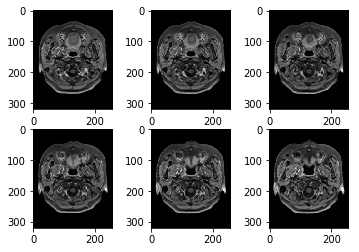

In [12]:
view(val_high[1])